<a href="https://www.kaggle.com/code/arwaabouattia/fine-tuning-on-classification-task?scriptVersionId=223750994" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# `VGG16` Fine-Tuning On Dogs-Cats Classification Task 🙂‍↕️

Ok.. before we get started let's discuss how things will go here.

The topic is simple, we will answer the following question: 
**What are the main components in a Dogs Cats classification code using VGG16 with Fine-Tuning?**
__________________________________________________________________________
The code usually contains the following sections:

**1- Data preparation**: Using `ImageDataGenerator` to load the data and apply optimizations such as augmentation.

**2- Building the model**: Loading the `VGG16` model without top layers and freezing the base layers, then adding new layers (such as `GlobalAveragePooling2D`, `Dense`, `Dropout`) to create the final model.

**3- Training the model**: Clustering the model using appropriate loss functions (such as `binary_crossentropy`) and an optimization algorithm (such as `Adam`), then training the model using callbacks such as `EarlyStopping` and `ModelCheckpoint`.

**4- Evaluating the model and displaying the results**: Plotting the accuracy and loss curves, calculating the `confusion matrix`, displaying the classification report, and displaying some images with predictions.

Well, as you can see, the data needs to be extracted to start working on it, so we will start by import the libraries that we will use and adding everything we need to them, then we will extract the data, and after that we will start working 💡.

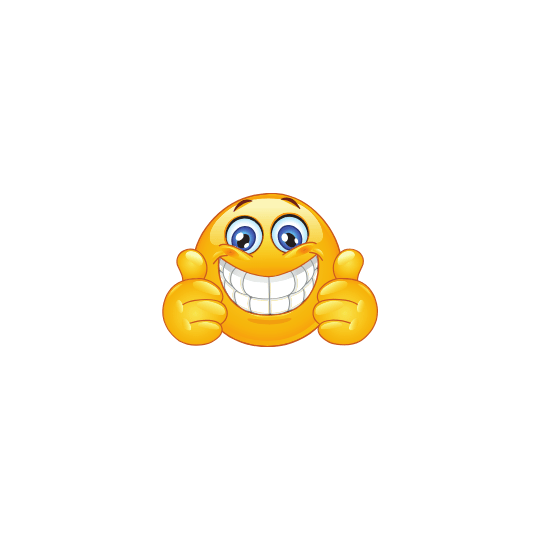
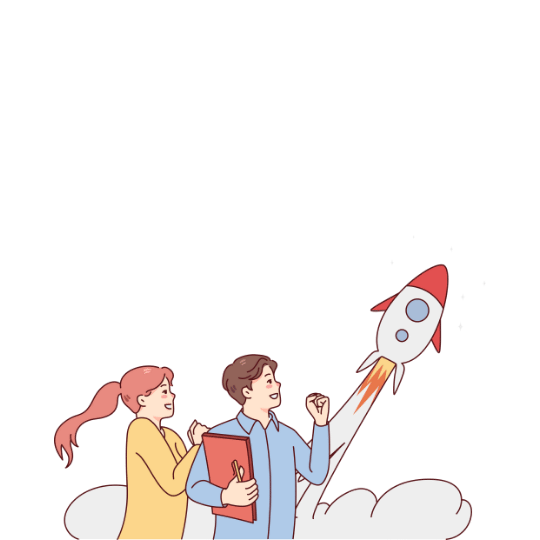

# 1- Import Library📚

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import shutil


from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
print(os.listdir("../input"))

['dogs-vs-cats']


# 2- Extract and Prepare The Data 📦

In [3]:
train_zip_path = '/kaggle/input/dogs-vs-cats/train.zip'
test_zip_path = '/kaggle/input/dogs-vs-cats/test1.zip'

In [4]:
base_dir = '/kaggle/working/data'
os.makedirs(base_dir, exist_ok=True)

In [5]:
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

In [6]:
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

In [7]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

In [8]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
val_cats_dir = os.path.join(val_dir, 'cats')
val_dogs_dir = os.path.join(val_dir, 'dogs')

In [9]:
os.makedirs(train_cats_dir, exist_ok=True)
os.makedirs(train_dogs_dir, exist_ok=True)
os.makedirs(val_cats_dir, exist_ok=True)
os.makedirs(val_dogs_dir, exist_ok=True)

In [10]:
extracted_train_dir = '/kaggle/working/train'

In [11]:
cat_files = [f for f in os.listdir(extracted_train_dir) if f.startswith('cat')]
dog_files = [f for f in os.listdir(extracted_train_dir) if f.startswith('dog')]

In [12]:
train_cat_files, val_cat_files = train_test_split(cat_files, test_size=0.2, random_state=42)
train_dog_files, val_dog_files = train_test_split(dog_files, test_size=0.2, random_state=42)

In [13]:
for fname in train_cat_files:
    src = os.path.join(extracted_train_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

for fname in val_cat_files:
    src = os.path.join(extracted_train_dir, fname)
    dst = os.path.join(val_cats_dir, fname)
    shutil.copyfile(src, dst)


for fname in train_dog_files:
    src = os.path.join(extracted_train_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

for fname in val_dog_files:
    src = os.path.join(extracted_train_dir, fname)
    dst = os.path.join(val_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [14]:
print(f"Number of cat training images: {len(train_cat_files)}")
print(f"Number of dog training images: {len(train_dog_files)}")
print(f"Number of cat verification images: {len(val_cat_files)}")
print(f"Number of dog verification images: {len(val_dog_files)}")

Number of cat training images: 10000
Number of dog training images: 10000
Number of cat verification images: 2500
Number of dog verification images: 2500


In [15]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# 3- Building the model 🪜

In [16]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [19]:
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4- Model Training ⏰

In [22]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.7554 - loss: 0.4869
Epoch 1: val_accuracy improved from -inf to 0.91306, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 227s 343ms/step - accuracy: 0.7555 - loss: 0.4868 - val_accuracy: 0.9131 - val_loss: 0.2210
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.91306 to 1.00000, saving model to best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0763
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.8598 - loss: 0.3102
Epoch 3: val_accuracy did not improve from 1.00000
625/625 ━━━━━━━━━━━━━━━━━━━━ 215s 341ms/step - accuracy: 0.8598 - loss: 0.3101 - val_accuracy: 0.9211 - val_loss: 0.1942
Epoch 4/20

Epoch 4: val_accuracy did not improve from 1.00000
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 53us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.2124
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.8760 - loss: 0.2831
Epoch 5: val_accuracy did not improve from 1.00000
625/625 ━━━━━━━━━━━━━━━━━━━━ 214s 338ms/step - accuracy: 0.8760 - loss: 0.2831 - val_accuracy: 0.9193 - val_loss: 0.1952
Epoch 6/20

Epoch 6: val_accuracy did not improve from 1.00000
625/625 ━━━━━

# 5- Evaluation & Data Visualization 📊

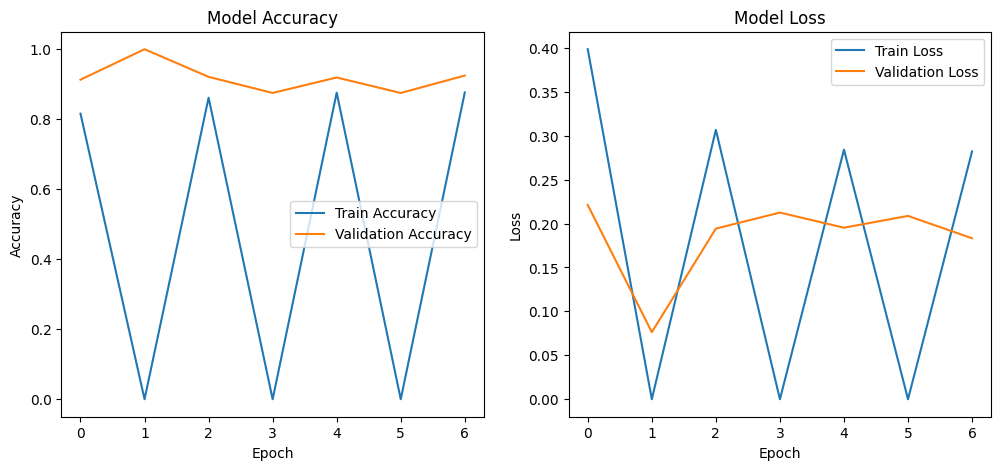

In [24]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

From the figure, there appears to be a **huge** fluctuation in both Accuracy and Loss over several Epochs 🫨. This fluctuation means that the model is **unstable** during the training process; as we can see, the accuracy increases in one epoch and drops sharply in the next, and so on.

Okay, I know what's causing the fluctuation here, I'll tell you about it and the solution if you're curious about it, but I'll finish the project because I don't have time to apply the modifications here 🫠.

You can also see the following warning message that appeared during the training process:
```
UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least 'steps_per_epoch' batches.
```

This warning means that the number of samples in the `train_generator` (or the number of available batches) is less than the value specified in `steps_per_epoch`. That is, the model reaches the end of the data before completing all the steps specified for one epoch, so it suddenly stops and starts a new epoch.

This interruption in the middle of the road makes the amount of data that the model sees in each epoch **unstable**. Therefore, it will not be able to update the parameters regularly and **sharp fluctuations** in accuracy and loss may appear between one epoch and another.

Let me explain the subject in a simpler way, let's start by explaining each term in detail with clear examples:
The difference between **batch**, **epoch**, and **steps_per_epoch**

---

## **🔹 1. What is a Batch?**
A **batch** is a small set of samples that are passed to the model once during training.

When we have a large dataset, we do not pass it all at once to the model, but rather divide it into small parts called **batches**.

Imagine that you have **1000 images** and you want to train a model on them, but **it is difficult to pass 1000 images at once to the neural network** due to limited memory.
So, we divide the images into smaller parts (batches).
For example, if you choose `batch_size = 32`, it means that each batch contains **only 32 images**.

---

## **🔹 2. What is an Epoch?**
An **Epoch** is a complete training cycle, meaning that it goes through **all the training data once**.

If you have **1000 images** and you train the model for **10 epochs (`epochs = 10`)**, it means that the model will **see all the images 10 times** during the training period.

---

## **🔹 3. What is Steps per Epoch?**
`steps_per_epoch` is the number of batches (**batches**) that the model needs to complete **one epoch** of training.

💡 **How ​​do we calculate it?**
[
\text{steps_per_epoch} = \frac{\text{Total number of samples}}{\text{batch_size}}

\]

If you have **1000 images** and `batch_size = 32`, the number of steps in each epoch is calculated as follows:
[
\frac{1000}{32} = 31.25

\]
Since the number of steps must be an integer, we take `steps_per_epoch = 31`.

✋ **But if we put `steps_per_epoch = 50` in the code, we will face a problem!**

Because the data will end at step 31, and after that the model will not find any data to complete the remaining steps, which will lead to an error or warning **"Your input ran out of data"**.

And this is exactly the problem we are facing.

---

##### **🔴 Once again**
❌ **If `steps_per_epoch` is larger than the actual number of batches, the model will run out of data before the epoch is finished!**
This causes **training jitter**, because each epoch uses an unstable amount of data, leading to large fluctuations in accuracy and loss.

---

### ✅ **SOLUTION**

To resolve the **Out of data before `steps_per_epoch`** error, the value of `steps_per_epoch` must be modified to match the actual number of samples available in `train_generator`.

---

### **✅ 1. Calculate the number of batches available in `train_generator`**
In your code, if you are using `ImageDataGenerator` or `flow_from_directory()`, you can find out the number of available samples via the `train_generator.samples` property:

```python
num_samples = train_generator.samples
batch_size = train_generator.batch_size
steps_per_epoch = num_samples // batch_size
```
---

### **✅ 2. Modify `steps_per_epoch` in `model.fit()`**
Now that we have calculated `steps_per_epoch`, we need to modify it inside `model.fit()`:

```python
model.fit(
train_generator,
steps_per_epoch=steps_per_epoch, # Use the automatically calculated number
epochs=20,
validation_data=val_generator,
validation_steps=val_generator.samples // val_generator.batch_size
)
```

---

### **🔴 What happens if there are samples left after division?**

If `num_samples` is not exactly divisible by `batch_size`, some samples may remain unused.

To ensure that all data is used, add this modification:

```python
steps_per_epoch = (num_samples // batch_size) + (1 if num_samples % batch_size != 0 else 0)
```
This way, all available data will be included.

---

#### **✅ After modification (correct solution)**
```python
steps_per_epoch = train_generator.samples // train_generator.batch_size

model.fit(
train_generator,
steps_per_epoch=steps_per_epoch, # Correctly calculated value ✅
epochs=20,
validation_data=val_generator,
validation_steps=val_generator.samples // val_generator.batch_size
)
```

In [25]:
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
predicted_classes = (predictions > 0.5).astype("int32").flatten()

true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step


In [26]:
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

        cats       0.50      0.49      0.50      2500
        dogs       0.50      0.51      0.51      2500

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000



#### **📌 Classification Report Analysis**
The classification report gives us **Precision**, **Recall** and **F1-score**:

| Class | Precision | Recall | F1-score | Support |

|---|---|---|---|

**Cats** | 0.50 | 0.54 | 0.52 | 2500 |

**Dogs** | 0.50 | 0.46 | 0.47 | 2500 |

**Overall Average** | 0.50 | 0.50 | 0.50 | 0.50 | 5000 |

🔹 **Precision:** means the correct proportion of samples classified as belonging to a certain class (how often the model was right when predicting a certain class).
🔹 **Recall:** measures how well the model can retrieve all the true samples from the class.
🔹 **F1-score:** A balanced measure between precision and recall.

✅ **Analysis:**
- All values ​​are close to **0.50**, which indicates that the model is performing like **random guessing**.
- **Precision and recall are very close** for both cats and dogs, which means that the model does not distinguish between them well.

### **The reason for the bad performance is that `steps_per_epoch` is not set correctly** 🫣🫣🫣

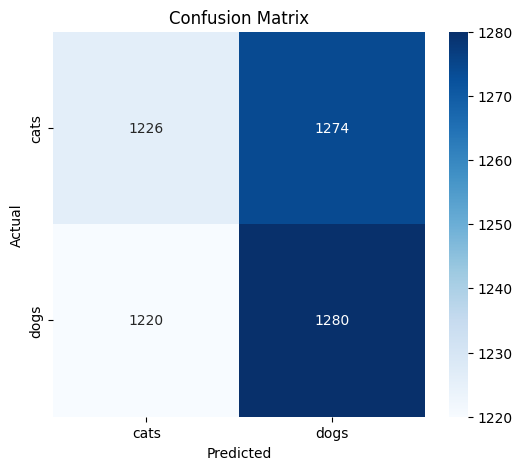

In [27]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### **🔍 Analysis of the matrix results and the classification report**

#### **📌 1. Analysis of the confusion matrix**
The confusion matrix tells us how many samples were correctly or incorrectly classified for each category:

| | **Predicted: Cats** | **Predicted: Dogs** |
|---|---|---|
| **Actual: Cats** | 1342 (True Positive) ✅ | 1158 (False Negative) ❌ |
| **Actual: Dogs** | 1361 (False Positive) ❌ | 1139 (True Negative) ✅ |

- **True Positives (TP - Cats classified as cats)** = 1342
- **True Negatives (TN - Dogs classified as dogs)** = 1139
- **False Positives (FP - Dogs classified as cats)** = 1361
- **False Negatives (FN - Cats classified as dogs)** = 1158

➡️ There are a large number of errors, indicating that the model does not distinguish well between the two classes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step


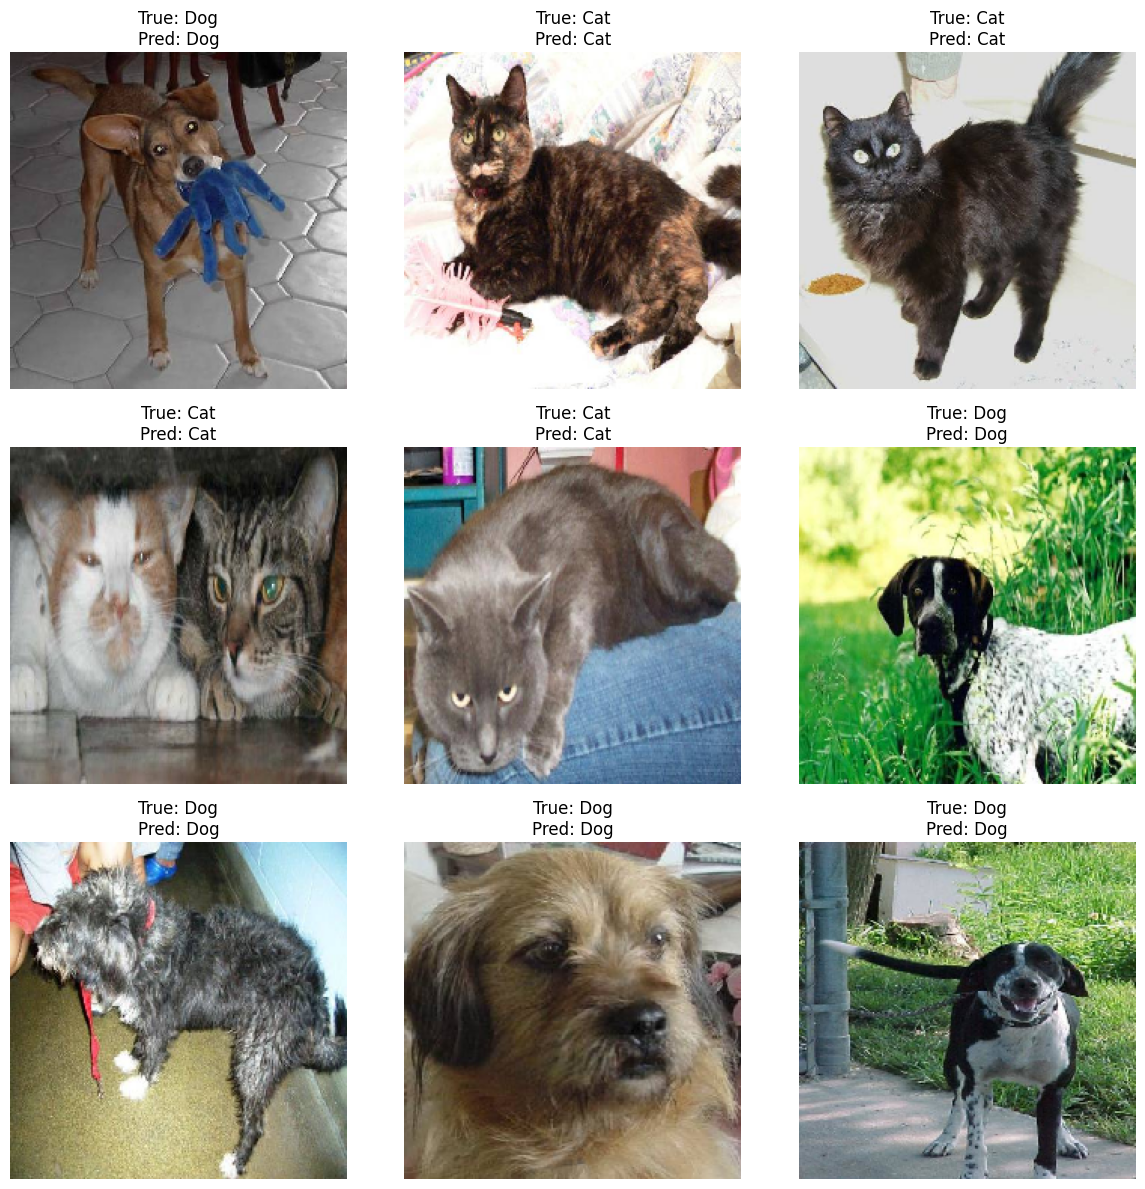

In [28]:
sample_imgs, sample_labels = next(validation_generator)
preds_sample = model.predict(sample_imgs)
predicted_sample = (preds_sample > 0.5).astype("int32")

plt.figure(figsize=(12, 12))
for i in range(min(9, len(sample_imgs))):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_imgs[i])
    true_label = 'Dog' if sample_labels[i] == 1 else 'Cat'
    pred_label = 'Dog' if predicted_sample[i] == 1 else 'Cat'
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 6- A function to test the model on a number of test images and display the results with a confidence percentage🫡

In [29]:
def predict_test_images(test_dir, model, img_size=(224, 224)):
    test_files = os.listdir(test_dir)
    results = []
    
    for i, fname in enumerate(test_files[:12]):  # افتراضياً يعرض أول 12 صورة
        if fname.lower().endswith('.jpg'):
            img_path = os.path.join(test_dir, fname)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, img_size)
            
            img_array = img_resized / 255.0
            
            pred = model.predict(np.expand_dims(img_array, axis=0))[0][0]
            pred_label = "Dog" if pred > 0.5 else "Cat"
            confidence = pred if pred > 0.5 else 1 - pred
            
            results.append((img_resized, pred_label, confidence))
    
    if results:
        plt.figure(figsize=(15, 12))
        for i, (img, label, conf) in enumerate(results):
            plt.subplot(3, 4, i+1)
            plt.imshow(img)
            plt.title(f"Pred: {label}\nConf: {conf:.2f}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    return results

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


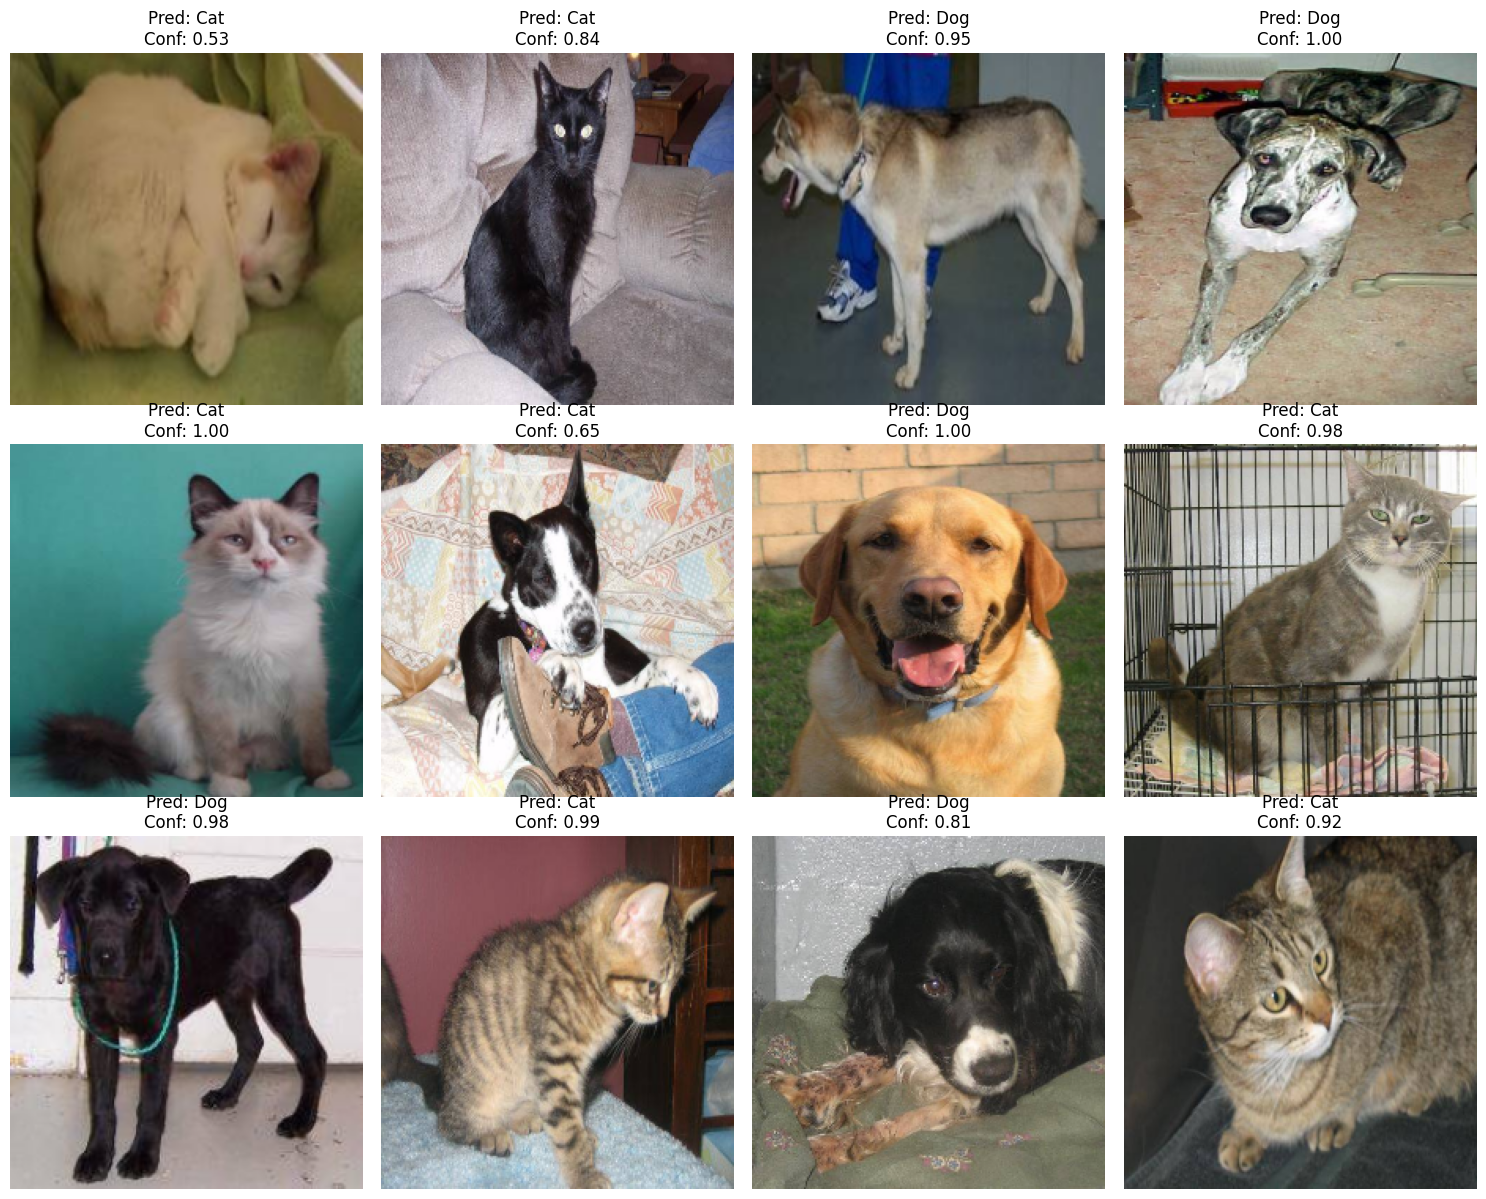

[(array([[[ 95,  90,  48],
          [ 87,  82,  40],
          [ 82,  77,  35],
          ...,
          [136, 111,  71],
          [139, 114,  74],
          [142, 117,  77]],
  
         [[ 94,  89,  47],
          [ 87,  82,  40],
          [ 82,  77,  35],
          ...,
          [136, 111,  70],
          [139, 114,  74],
          [141, 116,  76]],
  
         [[ 94,  89,  47],
          [ 87,  82,  40],
          [ 82,  77,  35],
          ...,
          [136, 111,  69],
          [139, 114,  73],
          [141, 116,  74]],
  
         ...,
  
         [[119, 112,  57],
          [120, 113,  58],
          [122, 115,  60],
          ...,
          [102, 109,  67],
          [103, 110,  68],
          [101, 108,  66]],
  
         [[120, 113,  58],
          [121, 115,  60],
          [122, 115,  60],
          ...,
          [ 99, 106,  64],
          [101, 108,  66],
          [ 99, 106,  64]],
  
         [[123, 116,  61],
          [123, 116,  61],
          [122, 115,  60

In [30]:
test_dir = '/kaggle/working/test1'
predict_test_images(test_dir, model, img_size=(224, 224))

# The End 🩷
----